# MHKiT Environmental Contours

Environmental contours of extreme sea states can be used as a part of reliability-based design for offshore structures, including wave energy converters (WECs). Environmental contours provide estimations of extreme sea states based on short-term data (e.g. 10 years used to estimate a 100-year event). These environmental contours describe extreme sea states by characterizing the resource, defining sea states for extreme condition analysis, and developing a framework for analyzing survivability of a design.

MHKiT includes functions adapted from the [WDRT](https://github.com/WEC-Sim/WDRT) for creating environmental contours of extreme sea states using a principal component analysis (PCA) methodology, with additional improvements for characterizing the joint probability distribution of sea states. As a demonstration, this notebook will walk through the following steps to find a 100-year sea state for NDBC buoy 46022 using 16 years of spectral wave density data.

 1. Request Spectral Wave Density Data from NDBC
 2. Calculate Hm0 and Te using the requested data
 3. Find the data's 100-year contour
 4. Plot the data and the 100-year contour

We will start by importing the necessary python packages (`scipy`, `pandas`, `numpy`), and MHKiT wave submodules (`resource`, `graphics`, and `io.ndbc`).

In [1]:
from mhkit.wave import resource, graphics, environmental_contours
import matplotlib.pyplot as plt
from mhkit.wave.io import ndbc
from scipy import stats
import pandas as pd
import numpy as np

## 1. Request Spectral Wave Density Data from NDBC
   
MHKiT can be used to request historical data from the National Data Buoy Center ([NDBC](https://www.ndbc.noaa.gov/)). This process is split into the following steps:

- Query available NDBC data  
- Select years of interest 
- Request Data from NDBC
- Convert the DataFrames to DateTime Index
 

### Query available NDBC data  
Looking at the help for the `ndbc.available_data` function (`help(ndbc.available_data)`) the function requires a parameter to be specified and optionally the user may provide a station ID as a string. A full list of available historical parameters can be found [here](https://www.ndbc.noaa.gov/data/historical/) although only some of these are currently supported.  We are interested in historical spectral wave density data `'swden'` (from which we may calculate Hm0 and Te). Additionally, we will specify the buoy number as `'46022'` to only return data associated with this site.

In [2]:
# Specify the parameter as spectral wave density and the buoy number to be 46022
parameter = 'swden'
buoy_number = '46022' 
ndbc_available_data= ndbc.available_data(parameter, buoy_number)
ndbc_available_data.head()

,id,year,filename
1478,46022,1996,46022w1996.txt.gz
1479,46022,1997,46022w1997.txt.gz
1480,46022,1998,46022w1998.txt.gz
1481,46022,1999,46022w1999.txt.gz
1482,46022,2000,46022w2000.txt.gz


### Select years of interest

The `ndbc.available_data` function has returned a DataFrame with columns 'id', 'year', and 'filename'. The year column is of type int while the filename and id (5 digit alpha-numeric specifier) are of type string. In this case, the years returned from `ndbc_available_data` span  1996 to the last complete year the buoy was operational (currently 2019 for 46022). For demonstration, we have decided we are interested in the data between the years 1996 and 2012 so we will create a new `years_of_interest` DataFrame which only contains years less than 2013.  

In [3]:
# Slice the available data to only include through year 2012
years_of_interest = ndbc_available_data[ndbc_available_data.year < 2013]
years_of_interest.head()

,id,year,filename
1478,46022,1996,46022w1996.txt.gz
1479,46022,1997,46022w1997.txt.gz
1480,46022,1998,46022w1998.txt.gz
1481,46022,1999,46022w1999.txt.gz
1482,46022,2000,46022w2000.txt.gz


### Request Data from NDBC

The filename column in our `years_of_interest` DataFrame and the parameter is needed to request the data. To get the data we can use the `ndbc.request_data` function to iterate over each buoy id and year in the passed DataFrame. This function will return the parameter data as a dictionary of DataFrames which may be accessed by buoy id and then the year for multiple buoys or just the year for a single buoy. 

In [4]:
# Get dictionary of parameter data by year
filenames= years_of_interest['filename']
ndbc_requested_data = ndbc.request_data(parameter, filenames)

### Convert the DataFrames to DateTime Index

The data returned for each year has a variable number of columns for the year, month, day, hour, minute, and the way the columns are formatted (this is a primary reason for return a dictionary of DataFrames indexed by years). A common step a user will want to take is to remove the inconsistent NDBC date/ time columns and create a standard DateTime index. The MHKiT function `ndbc.to_datetime_index` will perform this standardization by parsing the NDBC date/ time columns into DateTime format and setting this as the DataFrame Index and removing the NDBC date/ time columns. This function operates on a DateFrame therefore we will iterate over each year of the `ndbc_requested_data` dictionary.

In [5]:
# Lastly we will convert a DateTime Index 
ndbc_data={}
# Create a Datetime Index and remove NOAA date columns for each year
for year in ndbc_requested_data:
    year_data = ndbc_requested_data[year]
    ndbc_data[year] = ndbc.to_datetime_index(parameter, year_data)

# Display DataFrame of 46022 data from 1996
ndbc_data['1996'].head()

,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10,0.11,0.12,...,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,0.40
date,,,,,,,,,,,,,,,,,,,,,
1996-01-01 00:00:00,0.0,2.11,27.49,41.63,27.23,17.09,8.61,5.05,3.73,2.82,...,0.17,0.16,0.14,0.15,0.13,0.09,0.09,0.08,0.06,0.06
1996-01-01 01:00:00,0.0,1.20,25.13,57.69,32.59,11.75,6.33,4.16,4.22,2.98,...,0.22,0.18,0.20,0.10,0.12,0.10,0.07,0.07,0.05,0.04
1996-01-01 02:00:00,0.0,0.90,15.98,48.98,37.98,23.56,11.87,6.80,3.75,3.00,...,0.14,0.15,0.20,0.12,0.08,0.08,0.07,0.09,0.07,0.05
1996-01-01 03:00:00,0.0,0.38,14.73,38.55,34.99,14.79,9.23,5.54,4.43,2.99,...,0.17,0.20,0.17,0.14,0.12,0.09,0.07,0.05,0.06,0.04
1996-01-01 04:00:00,0.0,0.12,22.77,52.11,34.88,18.90,13.36,7.49,2.94,2.55,...,0.12,0.11,0.09,0.13,0.10,0.08,0.08,0.07,0.03,0.03


## 2. Calculate $H_{m0}$ and $T_e$ using the NDBC Data

A sea state may be characterized by significant wave height (Hm0) and energy period (Te). Using the historical spectral wave density data from NDBC, we can calculate these variables using MHKiT. Both Hm0 and Te return a single value for a given time (e.g. DateTime index). Currently, the data remains as a dictionary of DataFrames because the frequency binning (range and discretization) change across years of NDBC data. Once we have a single value for each DateTime we can combine all the data into a single DataFrame. 

In [6]:
# Intialize empty lists to store the results from each year
Hm0_list=[]
Te_list=[]

# Iterate over each year and save the result in the initalized dictionary
for year in ndbc_data:
    year_data = ndbc_data[year]
    Hm0_list.append(resource.significant_wave_height(year_data.T))
    Te_list.append(resource.energy_period(year_data.T))

# Concatenate list of Series into a single DataFrame
Te = pd.concat(Te_list ,axis=0)
Hm0 = pd.concat(Hm0_list ,axis=0)
Hm0_Te = pd.concat([Hm0,Te],axis=1)

# Drop any NaNs created from the calculation of Hm0 or Te
Hm0_Te.dropna(inplace=True)
# Sort the DateTime index
Hm0_Te.sort_index(inplace=True)
Hm0_Te

,Hm0,Te
date,,
1996-01-01 00:00:00,4.819627,14.856398
1996-01-01 01:00:00,5.004158,14.961679
1996-01-01 02:00:00,5.091169,14.244618
1996-01-01 03:00:00,4.679487,14.042246
1996-01-01 04:00:00,5.140895,14.478961
...,...,...
2012-12-31 19:00:00,1.995194,14.757854
2012-12-31 20:00:00,1.976259,14.360242
2012-12-31 21:00:00,2.658421,15.708162


## 3. Find the contour line for the 100 year

With the sea state data calculated, we can now use the modified I-FORM method to define reliability for a 100-year sea state based on the 17 years of spectral wave density data obtained from NDBC for buoy 46022. Reliability is the likelihood that a certain event will not occur in a given period. The period will define a line of constant probability in the joint probability of Hm0 and Te but individually each component different reliability (marginal distribution) which we can find by evaluating a normal cumulative distribution function (CDF). This CDF returns each component's quantiles along the iso-reliability line that finally allows us to calculate each sea state value (e.g. the 100-year contour values for Hm0 and Te). 

For more detail on the environmental contour method used here please refer to:
[Eckert-Gallup et. al 2016](https://www.sciencedirect.com/science/article/abs/pii/S0029801815006721)

To apply the environmental contours function we will specify a 100-year sea state, the sea state data (Hm0, Te), and the time difference between measurements (dt in seconds).

In [9]:
# Return period (years) of interest
period = 100  

# Remove Hm0 Outliers
Hm0_Te_clean = Hm0_Te[Hm0_Te.Hm0 < 20]

# Get only the values from the DataFrame
Hm0 = Hm0_Te_clean.Hm0.values  
Te  = Hm0_Te_clean.Te.values 

# Delta time of sea-states 
dt = (Hm0_Te_clean.index[2]-Hm0_Te_clean.index[1]).seconds  

# Get the contour values
copula = environmental_contours.copula(Hm0, Te, dt, period, 'PCA', return_PCA=True)
Hm0_contour=copula['PCA_x1']
Te_contour=copula['PCA_x2']

## 4. Plot overlay of the data and contour
Lastly we can use the MHKiT graphics module to create a contour plot which shows the data and resultant conotour line.

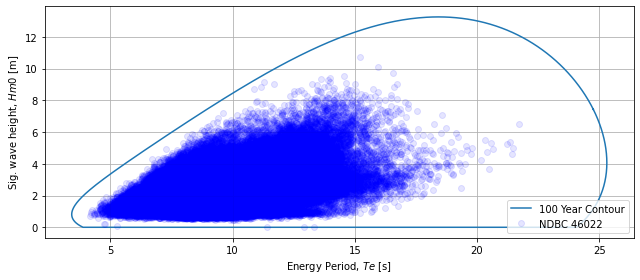

In [10]:
fig, ax = plt.subplots(figsize=(9,4))
ax = graphics.plot_environmental_contour(Te, Hm0, 
                                    Te_contour, Hm0_contour, 
                                    data_label='NDBC 46022', 
                                    contour_label='100 Year Contour',
                                    x_label = 'Energy Period, $Te$ [s]',
                                    y_label = 'Sig. wave height, $Hm0$ [m]', 
                                    ax=ax)

## Other contour methods

We start to calculate the copulas using the MHKiT `environmental_contours` module with the `copula` function. All copula methods are called using one copula function and simply changing the method used. The inputs for the `copula` function are the same as those into the `environmental_contour` with the additional method input. A single string method can be applied if only one copula is of interest or multiple methods can be sent in using a list of strings. Providing multiple methods at once is recommended as it will reduce the computational expense of parameters that are common across the copulas. 

We start by using the default settings for our Gaussian, Gumbel, and Clayton copulas. The `copula` function returns a dictionary with component 'x1' and 'x2' for each method. E.g. if the `copula` function were called on the `'gaussian'` method then copula would return a dictionary with keys `['gaussian_x1', 'gaussian_x2']`. The copula methods are a generalized mathematical method and therefore 'x1' and 'x2' are used in place of Hm0 and Te for the component values. 'x1' refers to the first array passed and 'x2' refers to the second array passed. In the example below 'x1' would refer to the Hm0 component of the coupla and 'x2' would refer to Te. 

Later in the notebook, we compare the MHKiT copula results to WDRT results as a code-to-code verification. For the Rosenblatt copulas, WDRT varied the copula binning slightly from the other methods. Here the Rosenblatt copula is calculated with those parameters and then adding those results to our `copulas` dictionary.

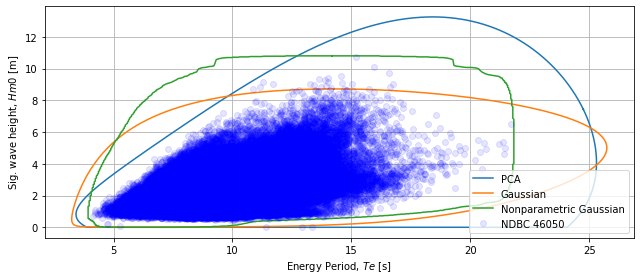

In [13]:
copulas =environmental_contours.copula(Hm0, Te, dt, period, method=['gaussian', 'nonparametric_gaussian'])

fig, ax = plt.subplots(figsize=(9,4))

Tes=[Te_contour]
Hm0s=[Hm0_contour]
methods=['gaussian', 'nonparametric_gaussian']
for method in methods:   
    Hm0s.append(copulas[f'{method}_x1'])
    Tes.append(copulas[f'{method}_x2'])

ax = graphics.plot_environmental_contour(Te, Hm0, 
                                         Tes, Hm0s,
                                         data_label='NDBC 46050', 
                                         contour_label=['PCA','Gaussian', 'Nonparametric Gaussian'],
                                         x_label = 'Energy Period, $Te$ [s]',
                                         y_label = 'Sig. wave height, $Hm0$ [m]', 
                                         ax=ax)

## Resource Clusters

Often in resource characterization we want to pick a few representative sea state to run an alaysis. To do this with the resource data in python we reccomend using a Gaussian Mixture Model (a more generalized k-means clustering method). Using sckitlearn this is very straigth forward. We combine our Hm0 and Te data into an N x 2 numpy array. We specify our number of components (number of representative sea states) and then call the fit method on the data. Fianlly, using the methods `means_` and `weights` we can organize the results into an easily digestable table.

In [14]:
# Intialize empty lists to store the results from each year
Hm0_list=[]
Tp_list=[]

# Iterate over each year and save the result in the initalized dictionary
for year in ndbc_data:
    year_data = ndbc_data[year]  
    Hm0_list.append(resource.significant_wave_height(year_data.T))
    Tp_list.append(resource.peak_period(year_data.T))

# Concatenate list of Series into a single DataFrame
Tp = pd.concat(Tp_list ,axis=0)
Hm0 = pd.concat(Hm0_list ,axis=0)
Hm0_Tp = pd.concat([Hm0,Tp],axis=1)

# Drop any NaNs created from the calculation of Hm0 or Te
Hm0_Tp.dropna(inplace=True)
# Sort the DateTime index
Hm0_Tp.sort_index(inplace=True)

# Remove Hm0 Outliers
Hm0_Tp_clean = Hm0_Tp[Hm0_Tp.Hm0 < 20]
Hm0_Tp_clean = Hm0_Tp[Hm0_Tp.Tp < 30]

# Get only the values from the DataFrame
Hm0 = Hm0_Tp_clean.Hm0.values  
Tp  = Hm0_Tp_clean.Tp.values 


Hm0_Tp

,Hm0,Tp
date,,
1996-01-01 00:00:00,4.819627,16.666667
1996-01-01 01:00:00,5.004158,16.666667
1996-01-01 02:00:00,5.091169,16.666667
1996-01-01 03:00:00,4.679487,16.666667
1996-01-01 04:00:00,5.140895,16.666667
...,...,...
2012-12-31 19:00:00,1.995194,19.047619
2012-12-31 20:00:00,1.976259,17.391304
2012-12-31 21:00:00,2.658421,17.391304


In [15]:
from sklearn.mixture import GaussianMixture

# Compute Gaussian Mixture Model
X = np.vstack((Tp, Hm0)).T
gmm = GaussianMixture(n_components=8).fit(X)

# Save centers and weights
results = pd.DataFrame(gmm.means_, columns=['Tp','Hm0'])
results['weights'] = gmm.weights_
results

C:\Users\sterl\anaconda3\lib\site-packages\scipy\special\_logsumexp.py:110: RuntimeWarning: underflow encountered in exp
  tmp = np.exp(a - a_max)
C:\Users\sterl\anaconda3\lib\site-packages\sklearn\mixture\_gaussian_mixture.py:675: RuntimeWarning: underflow encountered in exp
  _estimate_gaussian_parameters(X, np.exp(log_resp), self.reg_covar,
C:\Users\sterl\anaconda3\lib\site-packages\sklearn\mixture\_gaussian_mixture.py:166: RuntimeWarning: underflow encountered in multiply
  covariances[k] = np.dot(resp[:, k] * diff.T, diff) / nk[k]


,Tp,Hm0,weights
0,13.731597,3.635186,0.148869
1,8.050337,2.025295,0.160801
2,9.421126,2.445572,0.167456
3,11.570614,2.414267,0.257361
4,14.207381,1.670860,0.081698
5,19.913805,2.949608,0.019102
6,16.652439,3.224668,0.064677
7,6.863652,1.468030,0.100036


### Viewing the Clusters

We can visually look at the clusters by predicting which cluster each datapoint belongs in. Then we can plot the means on top of this to show where each cluster is centered and how the data points are being catagorized.

Text(0, 0.5, 'Sig. wave height, $Hm0$ [m]')

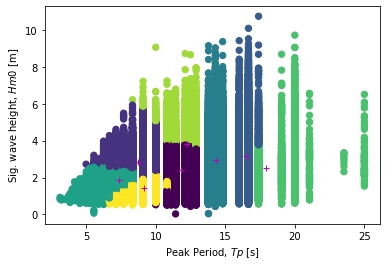

In [11]:
# Plot the Sections of Data
labels = gmm.predict(X)
plt.scatter(Tp, Hm0, c=labels, s=40)
plt.plot(results.Tp, results.Hm0, 'm+')
plt.xlabel('Peak Period, $Tp$ [s]')
plt.ylabel('Sig. wave height, $Hm0$ [m]')